## Soft Actor-Critic (SAC)

In [ ]:
!apt-get install -y \
    libgl1-mesa-dev \
    libgl1-mesa-glx \
    libglew-dev \
    xvfb \
    libosmesa6-dev \
    software-properties-common \
    patchelf

!pip install \
    free-mujoco-py \
    gym==0.21 \
    pytorch-lightning==1.6.0 \
    optuna \
    pyvirtualdisplay \
    PyOpenGL \
    PyOpenGL-accelerate

#### Setup virtual display

In [1]:
from pyvirtualdisplay import Display
Display(visible=False, size=(1400, 900)).start()

#### Import the necessary code libraries

In [1]:
import copy
import gymnasium as gym
import gymnasium_robotics
import torch
import itertools
import random

import numpy as np
import torch.nn.functional as F

from collections import deque, namedtuple
from IPython.display import HTML
from base64 import b64encode

from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data.dataset import IterableDataset
from torch.optim import AdamW
from torch.distributions.normal import Normal

from pytorch_lightning import LightningModule, Trainer

from gymnasium.wrappers import RecordVideo, RecordEpisodeStatistics, \
  FilterObservation, FlattenObservation, TimeLimit


device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
num_gpus = torch.cuda.device_count()

In [2]:
device

'cuda:0'

In [35]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0" 

In [4]:
device

'cuda:0'

In [3]:
def display_video(episode=0):
  video_file = open(f'/content/videos3/rl-video-episode-{episode}.mp4', "r+b").read()
  video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"
  return HTML(f"<video width=600 controls><source src='{video_url}'></video>")

#### Create the replay buffer

In [4]:
class ReplayBuffer:

  def __init__(self, capacity):
    self.buffer = deque(maxlen=capacity)

  def __len__(self):
    return len(self.buffer)
  
  def append(self, experience):
    self.buffer.append(experience)
  
  def sample(self, batch_size):
    return random.sample(self.buffer, batch_size)

In [5]:
class RLDataset(IterableDataset):

  def __init__(self, buffer, sample_size=400):
    self.buffer = buffer
    self.sample_size = sample_size
  
  def __iter__(self):
    for experience in self.buffer.sample(self.sample_size):
      yield experience

#### Create the environment

In [8]:
env=gym.make('FetchReachDense-v1', render_mode='rgb_array')

/home/akhters/.local/lib/python3.8/site-packages/gymnasium/envs/registration.py:513: DeprecationWarning: WARN: The environment FetchReachDense-v1 is out of date. You should consider upgrading to version `v2`.
  logger.deprecation(
/home/akhters/.local/lib/python3.8/site-packages/gymnasium_robotics/envs/robot_env.py:361: UserWarning: WARN: This version of the mujoco environments depends on the mujoco-py bindings, which are no longer maintained and may stop working. Please upgrade to the v4 versions of the environments (which depend on the mujoco python bindings instead), unless you are trying to precisely replicate previous works).
  logger.warn(


In [ ]:
env.reset()
#the value in the observation key refers to the joints of the robot that we can act on to change the position of the robot and they are the x, y and z co-oridnates
#the value under the desired goal key refers to the x, y and z positions of the environment that we have to reach by moving our robot
#the value under the achieved goal refers to the x, y and z position of the tipped of the robot that we have achieved at this moment of time
#our goal is to make our achieved goal equal to the desired goal

Found 4 GPUs for rendering. Using device 0.


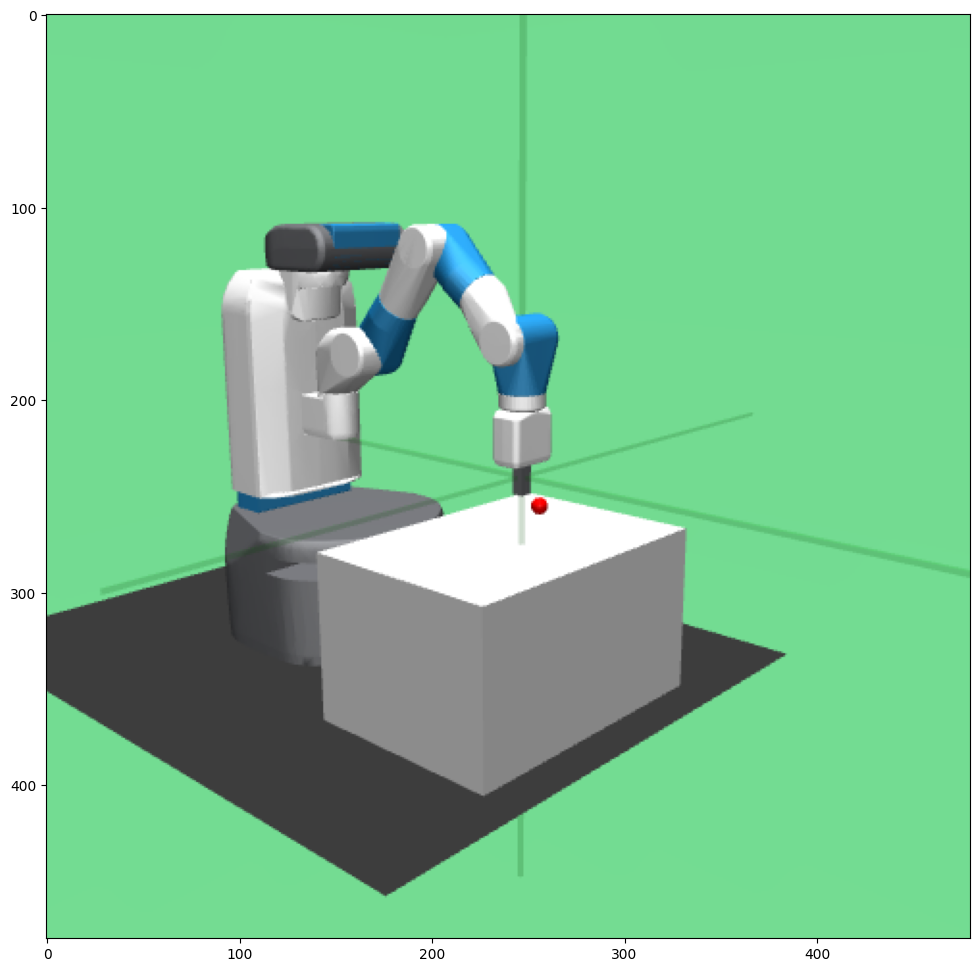

In [7]:
import matplotlib.pyplot as plt
# Render the frame as an RGB array
# env.step(env.action_space.sample())

# Render the frame
frame = env.render()

# Display the frame using matplotlib
plt.figure(figsize=(12,12))
plt.imshow(frame)
plt.show()

In [ ]:
env.action_space
#our action space consists of four values, between -1.0 to 1.0
#each of the values decides how much torque we are going to apply to each of the joints 
# and the last one is how much torque we are applying on the tip of the gripper to open it and close it so that the robot can grab objects
#now this environment has 2 flavours, every time we move our robot, the reward will be -1 until we touch the red dot with our gripper
#this kind of reward function is basically called sparse rewards because only time we achieve reward above the baseline is actually when we reach the goal
#but this version of an environment is an easier one, we are using dense rewards, that is, every time we move our robot, the agent will get a reward proportional to the distance to the goal
#it will be negative value and as the tip of the robot moves closer to the goal position, the negative reward will decrease and upon reaching the goal position, the reward will be 0
#envrionments with dense rewards are easier to config because they get a constant feedback from the environment, and they can till learn without waiting even if they haven't performed the task correcly before
#when we work with dense rewards, we don't need the achieved_goal values, we only need information about the joints of the robots and the desired_goal values.
#this achieved_goal key will be used in the next algorithm, when we consider sparse reward values using hindsight experience replay technique

In [6]:
class RepeatActionWrapper(gym.Wrapper):
  def __init__(self, env, n):
    super().__init__(env)
    self.env = env
    self.n = n
      
  def step(self, action):
    done = False
    total_reward = 0.0
    for _ in range(self.n):
      next_state, reward, done, info = self.env.step(action)
      total_reward += reward
      if done:
        break
    return next_state, total_reward, done, info

In [7]:
def create_environment(name):
  env = gym.make(name, render_mode='rgb_array')
  # env = TimeLimit(env, max_episode_steps=400)
  #the following two are the just modifications to our observation so that our algorithm can process them
  env = FilterObservation(env, ['observation', 'desired_goal'])#we only need two keys observation
  env = FlattenObservation(env)#we don't want a dictionary representation, we want a flat array that consists of an array containing the valuse of observation and an array containing the values of desired_goal
  env = RecordVideo(env, video_folder='./videos3', episode_trigger=lambda x: x % 50 == 0)
  # env = RepeatActionWrapper(env, n=4)
  env = RecordEpisodeStatistics(env)
  return env

In [ ]:
env = create_environment('FetchReachDense-v1')
hello, _=env.reset()
next_obs, reward, done, info, _= env.step(env.action_space.sample())
print(next_obs)
print(reward)
print(done)
print(info)
print(_)

In [ ]:
hello

In [ ]:
print(type(hello))

In [ ]:
hello[0]

#### Update the target network

In [8]:
def polyak_average(net, target_net, tau=0.01):
    for qp, tp in zip(net.parameters(), target_net.parameters()):
        tp.data.copy_(tau * qp.data + (1 - tau) * tp.data)

#### Create the Deep Q-Network

In [9]:
class DQN(nn.Module):

  def __init__(self, hidden_size, obs_size, out_dims):
    super().__init__()
    self.net = nn.Sequential(
        nn.Linear(obs_size + out_dims, hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size, hidden_size),
        nn.ReLU(),           
        nn.Linear(hidden_size, 1),
    )

  def forward(self, state, action):
    if isinstance(state, np.ndarray):
      state = torch.from_numpy(state).to(device)
    if isinstance(action, np.ndarray):
      action = torch.from_numpy(action).to(device)
    in_vector = torch.hstack((state, action))
    return self.net(in_vector.float())

#### Create the gradient policy

In [10]:
class GradientPolicy(nn.Module):

  def __init__(self, hidden_size, obs_size, out_dims, max):
    super().__init__()

    self.max = torch.from_numpy(max).to(device)

    self.net = nn.Sequential(
        nn.Linear(obs_size, hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size, hidden_size),
        nn.ReLU()
    )
    self.linear_mu = nn.Linear(hidden_size, out_dims)
    self.linear_std = nn.Linear(hidden_size, out_dims)
    # self.linear_log_std = nn.Linear(hidden_size, out_dims)

  def forward(self, obs):
    if isinstance(obs, np.ndarray):
      obs = torch.from_numpy(obs).to(device)
    x = self.net(obs.float())
    mu = self.linear_mu(x)
    std = self.linear_std(x)
    std = F.softplus(std) + 1e-3#ensurse that this value stays positive

    dist = Normal(mu, std)
    action = dist.rsample()
    log_prob = dist.log_prob(action)#actions->[v1, v2, v3, v4]
    #we will get 4 values of log_prob, that is, log of probability of each of the values in the action array
    #but what we want is a value of log_prob of the whole action array itself, the following performs this computation
    log_prob = log_prob.sum(dim=-1, keepdim=True)#dim=-1(we wish to mantain batches, and that is why we are giving dimension=-1, which is the last dimension, dimension 1 will be the batch size
    #and we want to add together only the probablilities of the same row)
    log_prob -= (2* (np.log(2) - action - F.softplus(-2*action))).sum(dim=-1, keepdim=True)
    #the probability of taking an action goes from 0 to 1, which means the log of probabilities goes from -ve infinity to zero. if the probability of selecting that action is very close to zero
    #the logarithm of it will be huge negative number and that can cause numerical instability in the learning process. To solve it, in the research paper where they introduced the soft-actor critc algorithm,
    #they described the above operation to make the log probabilities more stable
    action = torch.tanh(action) * self.max#bringing the values of action withing the allowed range of actions
    return action, log_prob

#### Soft actor-critic algorithm

In [11]:
class SAC(LightningModule):

  def __init__(self, env_name, capacity=100_000, batch_size=256, lr=1e-3, 
               hidden_size=256, gamma=0.99, loss_fn=F.smooth_l1_loss, optim=AdamW, 
               samples_per_epoch=1_000, tau=0.05, alpha=0.02, epsilon=0.05):
    
    super().__init__()
    # print("Inside __init__ function")
    self.automatic_optimization = False  # Disable automatic optimization
    self.env = create_environment(env_name)

    obs_size = self.env.observation_space.shape[0]
    action_dims = self.env.action_space.shape[0]
    max_action = self.env.action_space.high

    self.q_net1 = DQN(hidden_size, obs_size, action_dims)
    self.q_net2 = DQN(hidden_size, obs_size, action_dims)
    self.policy = GradientPolicy(hidden_size, obs_size, action_dims, max_action)

    self.target_policy = copy.deepcopy(self.policy)
    self.target_q_net1 = copy.deepcopy(self.q_net1)
    self.target_q_net2 = copy.deepcopy(self.q_net2)

    self.buffer = ReplayBuffer(capacity=capacity)

    self.save_hyperparameters()

    while len(self.buffer) < self.hparams.samples_per_epoch:
      print(f"{len(self.buffer)} samples in experience buffer. Filling...")
      self.play_episodes()

  @torch.no_grad()
  def play_episodes(self, policy=None):
      # print("Inside play_episode")
      obs, _ = self.env.reset()
      done = False
      truncate = False
      # i=0
      while not (done or truncate):
        if policy and random.random() > self.hparams.epsilon:
          action, _ = self.policy(obs)
          action = action.cpu().numpy()
        else:
          action = self.env.action_space.sample()
        # print(f"Inside this loop {i}")
        next_obs, reward, done, truncate, info = self.env.step(action)
        exp = (obs, action, reward, done, next_obs)
        self.buffer.append(exp)
        obs = next_obs
        # if len(self.buffer) >= self.hparams.samples_per_epoch:
          # print(f"Buffer filled with {len(self.buffer)} samples.")
          # break
        # print(f"Value of truncate is {truncate} and i is {i}")
        # i+=1

  def forward(self, x):
    output = self.policy(x)
    return output

  def configure_optimizers(self):
    # print("Iniside configure_optimizers function")
    # q_net_parameters = itertools.chain(self.q_net1.parameters(), self.q_net2.parameters())
    # q_net_optimizer = self.hparams.optim(q_net_parameters, lr=self.hparams.lr)
    q_net1_optimizer = self.hparams.optim(self.q_net1.parameters(), lr=self.hparams.lr)
    q_net2_optimizer = self.hparams.optim(self.q_net2.parameters(), lr=self.hparams.lr)
    policy_optimizer = self.hparams.optim(self.policy.parameters(), lr=self.hparams.lr)
    return [q_net1_optimizer, q_net2_optimizer, policy_optimizer]

  def train_dataloader(self):
    # print("Inside train_dataloader function")
    dataset = RLDataset(self.buffer, self.hparams.samples_per_epoch)
    dataloader = DataLoader(
        dataset=dataset,
        batch_size=self.hparams.batch_size,
    )
    return dataloader

  def training_step(self, batch, batch_idx):
    # print("Inside traning_step function")
    states, actions, rewards, dones, next_states = batch
    rewards = rewards.unsqueeze(1)
    dones = dones.unsqueeze(1)

    # if optimizer_idx == 0:

    action_values1 = self.q_net1(states, actions)
    action_values2 = self.q_net2(states, actions)

    target_actions, target_log_probs = self.target_policy(next_states)

    next_action_values = torch.min(
        self.target_q_net1(next_states, target_actions),
        self.target_q_net2(next_states, target_actions)
    )
    next_action_values[dones] = 0.0

    expected_action_values = rewards + self.hparams.gamma * (next_action_values - self.hparams.alpha * target_log_probs)
    #- self.hparams.alpha * target_log_probs)= this will be a positive value. The lesser the probability, the bigger will be this positive value and the larger the bonus we will be adding for this action
    opt_q_net1, opt_q_net2, opt_policy = self.optimizers()
    q_loss1 = self.hparams.loss_fn(action_values1, expected_action_values)
    q_loss2 = self.hparams.loss_fn(action_values2, expected_action_values)
    opt_q_net1.zero_grad()
    q_loss1.backward(retain_graph=True)
    opt_q_net1.step()
    opt_q_net2.zero_grad()
    q_loss2.backward()
    opt_q_net2.step()
    q_loss_total = q_loss1 + q_loss2
    self.log("episode/Q-Loss", q_loss_total)
    

  # elif optimizer_idx == 1:

    actions, log_probs = self.policy(states)

    action_values = torch.min(
        self.q_net1(states, actions),
        self.q_net2(states, actions)
    )

    policy_loss = (self.hparams.alpha * log_probs - action_values).mean()#we are trying to maximise the action values as much as possible while keeping the probability of selecting 
    #unfrequent actions fairly high
    opt_policy.zero_grad()
    policy_loss.backward()
    opt_policy.step()
    self.log("episode/Policy Loss", policy_loss)
    

  def on_train_epoch_end(self):
    # print("Inside on_train_epoch_end function")
    self.play_episodes(policy=self.policy)

    polyak_average(self.q_net1, self.target_q_net1, tau=self.hparams.tau)
    polyak_average(self.q_net2, self.target_q_net2, tau=self.hparams.tau)
    polyak_average(self.policy, self.target_policy, tau=self.hparams.tau)

    self.log("episode/episode_return", float(self.env.return_queue[-1]))

In [12]:
# Start tensorboard.
!rm -r /content/lightning_logs/
!rm -r /content/videos/
%load_ext tensorboard
%tensorboard --logdir /content/lightning_logs/

rm: cannot remove '/content/lightning_logs/': No such file or directory
rm: cannot remove '/content/videos/': No such file or directory


ERROR: Failed to start `tensorboard`: [Errno 8] Exec format error:
'tensorboard'

In [23]:
import torch
print(torch.cuda.is_available()) 

True


In [13]:
algo = SAC('FetchReachDense-v1', lr=1e-3, alpha=0.002, tau=0.1)

trainer = Trainer(
    # gpus=num_gpus, 
    max_epochs=10_000,
    log_every_n_steps=1
)

trainer.fit(algo)

/home/akhters/.local/lib/python3.8/site-packages/gymnasium/envs/registration.py:513: DeprecationWarning: WARN: The environment FetchReachDense-v1 is out of date. You should consider upgrading to version `v2`.
  logger.deprecation(
/home/akhters/.local/lib/python3.8/site-packages/gymnasium_robotics/envs/robot_env.py:361: UserWarning: WARN: This version of the mujoco environments depends on the mujoco-py bindings, which are no longer maintained and may stop working. Please upgrade to the v4 versions of the environments (which depend on the mujoco python bindings instead), unless you are trying to precisely replicate previous works).
  logger.warn(
/home/akhters/.local/lib/python3.8/site-packages/gymnasium/wrappers/record_video.py:94: UserWarning: WARN: Overwriting existing videos at /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


0 samples in experience buffer. Filling...
Found 4 GPUs for rendering. Using device 0.
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-0.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-0.mp4
50 samples in experience buffer. Filling...
100 samples in experience buffer. Filling...
150 samples in experience buffer. Filling...
200 samples in experience buffer. Filling...
250 samples in experience buffer. Filling...
300 samples in experience buffer. Filling...
350 samples in experience buffer. Filling...
400 samples in experience buffer. Filling...
450 samples in experience buffer. Filling...
500 samples in experience buffer. Filling...
550 samples in experience buffer. Filling...
600 samples in experience buffer. Filling...
650 samples in experience buffer. Filling...
700 samples in experience buffer. Filling...
750 samples in experience buffer. Filling...
800 samples in experience buffer. Filling...
850 samples in experience buffer. Filling...
900 samples in experience buffer. Filling...
950 samples in experience buffer. Filling...


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3060 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
2024-07-06 01:19:26.586857: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-06 01:19:27.687660: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type      

Training: |          | 0/? [00:00<?, ?it/s]

Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-50.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-50.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-50.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-100.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-100.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-100.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-150.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-150.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-150.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-200.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-200.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-200.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-250.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-250.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-250.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-300.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-300.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-300.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-350.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-350.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-350.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-400.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-400.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-400.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-450.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-450.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-450.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-500.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-500.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-500.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-550.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-550.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-550.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-600.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-600.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-600.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-650.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-650.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-650.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-700.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-700.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-700.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-750.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-750.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-750.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-800.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-800.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-800.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-850.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-850.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-850.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-900.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-900.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-900.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-950.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-950.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-950.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-1000.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-1000.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-1000.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-1050.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-1050.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-1050.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-1100.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-1100.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-1100.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-1150.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-1150.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-1150.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-1200.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-1200.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-1200.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-1250.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-1250.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-1250.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-1300.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-1300.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-1300.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-1350.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-1350.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-1350.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-1400.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-1400.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-1400.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-1450.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-1450.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-1450.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-1500.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-1500.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-1500.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-1550.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-1550.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-1550.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-1600.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-1600.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-1600.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-1650.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-1650.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-1650.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-1700.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-1700.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-1700.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-1750.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-1750.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-1750.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-1800.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-1800.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-1800.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-1850.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-1850.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-1850.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-1900.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-1900.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-1900.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-1950.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-1950.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-1950.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-2000.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-2000.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-2000.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-2050.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-2050.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-2050.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-2100.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-2100.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-2100.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-2150.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-2150.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-2150.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-2200.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-2200.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-2200.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-2250.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-2250.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-2250.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-2300.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-2300.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-2300.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-2350.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-2350.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-2350.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-2400.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-2400.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-2400.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-2450.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-2450.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-2450.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-2500.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-2500.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-2500.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-2550.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-2550.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-2550.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-2600.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-2600.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-2600.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-2650.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-2650.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-2650.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-2700.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-2700.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-2700.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-2750.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-2750.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-2750.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-2800.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-2800.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-2800.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-2850.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-2850.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-2850.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-2900.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-2900.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-2900.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-2950.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-2950.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-2950.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-3000.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-3000.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-3000.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-3050.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-3050.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-3050.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-3100.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-3100.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-3100.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-3150.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-3150.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-3150.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-3200.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-3200.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-3200.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-3250.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-3250.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-3250.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-3300.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-3300.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-3300.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-3350.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-3350.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-3350.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-3400.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-3400.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-3400.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-3450.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-3450.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-3450.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-3500.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-3500.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-3500.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-3550.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-3550.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-3550.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-3600.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-3600.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-3600.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-3650.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-3650.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-3650.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-3700.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-3700.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-3700.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-3750.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-3750.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-3750.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-3800.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-3800.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-3800.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-3850.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-3850.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-3850.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-3900.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-3900.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-3900.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-3950.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-3950.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-3950.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-4000.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-4000.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-4000.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-4050.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-4050.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-4050.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-4100.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-4100.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-4100.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-4150.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-4150.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-4150.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-4200.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-4200.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-4200.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-4250.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-4250.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-4250.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-4300.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-4300.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-4300.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-4350.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-4350.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-4350.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-4400.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-4400.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-4400.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-4450.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-4450.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-4450.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-4500.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-4500.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-4500.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-4550.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-4550.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-4550.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-4600.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-4600.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-4600.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-4650.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-4650.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-4650.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-4700.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-4700.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-4700.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-4750.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-4750.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-4750.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-4800.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-4800.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-4800.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-4850.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-4850.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-4850.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-4900.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-4900.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-4900.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-4950.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-4950.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-4950.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-5000.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-5000.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-5000.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-5050.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-5050.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-5050.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-5100.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-5100.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-5100.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-5150.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-5150.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-5150.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-5200.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-5200.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-5200.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-5250.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-5250.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-5250.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-5300.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-5300.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-5300.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-5350.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-5350.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-5350.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-5400.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-5400.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-5400.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-5450.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-5450.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-5450.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-5500.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-5500.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-5500.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-5550.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-5550.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-5550.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-5600.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-5600.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-5600.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-5650.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-5650.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-5650.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-5700.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-5700.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-5700.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-5750.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-5750.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-5750.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-5800.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-5800.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-5800.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-5850.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-5850.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-5850.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-5900.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-5900.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-5900.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-5950.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-5950.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-5950.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-6000.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-6000.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-6000.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-6050.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-6050.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-6050.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-6100.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-6100.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-6100.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-6150.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-6150.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-6150.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-6200.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-6200.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-6200.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-6250.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-6250.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-6250.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-6300.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-6300.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-6300.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-6350.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-6350.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-6350.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-6400.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-6400.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-6400.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-6450.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-6450.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-6450.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-6500.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-6500.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-6500.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-6550.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-6550.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-6550.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-6600.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-6600.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-6600.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-6650.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-6650.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-6650.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-6700.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-6700.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-6700.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-6750.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-6750.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-6750.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-6800.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-6800.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-6800.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-6850.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-6850.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-6850.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-6900.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-6900.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-6900.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-6950.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-6950.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-6950.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-7000.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-7000.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-7000.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-7050.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-7050.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-7050.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-7100.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-7100.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-7100.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-7150.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-7150.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-7150.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-7200.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-7200.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-7200.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-7250.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-7250.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-7250.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-7300.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-7300.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-7300.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-7350.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-7350.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-7350.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-7400.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-7400.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-7400.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-7450.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-7450.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-7450.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-7500.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-7500.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-7500.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-7550.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-7550.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-7550.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-7600.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-7600.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-7600.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-7650.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-7650.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-7650.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-7700.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-7700.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-7700.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-7750.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-7750.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-7750.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-7800.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-7800.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-7800.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-7850.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-7850.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-7850.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-7900.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-7900.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-7900.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-7950.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-7950.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-7950.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-8000.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-8000.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-8000.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-8050.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-8050.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-8050.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-8100.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-8100.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-8100.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-8150.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-8150.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-8150.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-8200.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-8200.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-8200.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-8250.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-8250.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-8250.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-8300.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-8300.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-8300.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-8350.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-8350.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-8350.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-8400.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-8400.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-8400.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-8450.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-8450.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-8450.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-8500.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-8500.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-8500.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-8550.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-8550.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-8550.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-8600.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-8600.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-8600.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-8650.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-8650.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-8650.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-8700.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-8700.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-8700.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-8750.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-8750.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-8750.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-8800.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-8800.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-8800.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-8850.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-8850.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-8850.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-8900.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-8900.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-8900.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-8950.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-8950.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-8950.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-9000.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-9000.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-9000.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-9050.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-9050.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-9050.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-9100.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-9100.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-9100.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-9150.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-9150.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-9150.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-9200.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-9200.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-9200.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-9250.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-9250.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-9250.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-9300.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-9300.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-9300.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-9350.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-9350.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-9350.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-9400.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-9400.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-9400.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-9450.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-9450.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-9450.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-9500.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-9500.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-9500.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-9550.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-9550.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-9550.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-9600.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-9600.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-9600.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-9650.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-9650.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-9650.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-9700.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-9700.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-9700.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-9750.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-9750.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-9750.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-9800.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-9800.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-9800.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-9850.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-9850.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-9850.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-9900.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-9900.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-9900.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-9950.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-9950.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-9950.mp4
Moviepy - Building video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-10000.mp4.
Moviepy - Writing video /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-10000.mp4



Moviepy - Done !
Moviepy - video ready /home/akhters/Reinforcement Learning/advanced_rl_dqn_to_sac_complete-main/videos3/rl-video-episode-10000.mp4


`Trainer.fit` stopped: `max_epochs=10000` reached.


In [18]:
torch._C._cuda_init()

RuntimeError: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero.